To ensure that every samples has GO annotations that represent a complete subgraph of the Gene Ontology, we'll leverage the hierarchical structure of the GO DAG to include terms of any missing descendants.

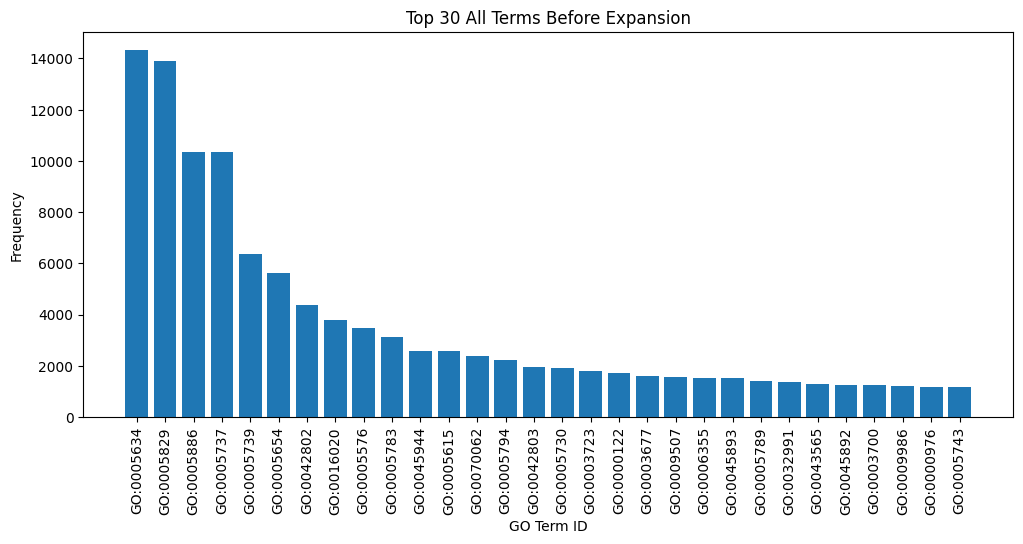

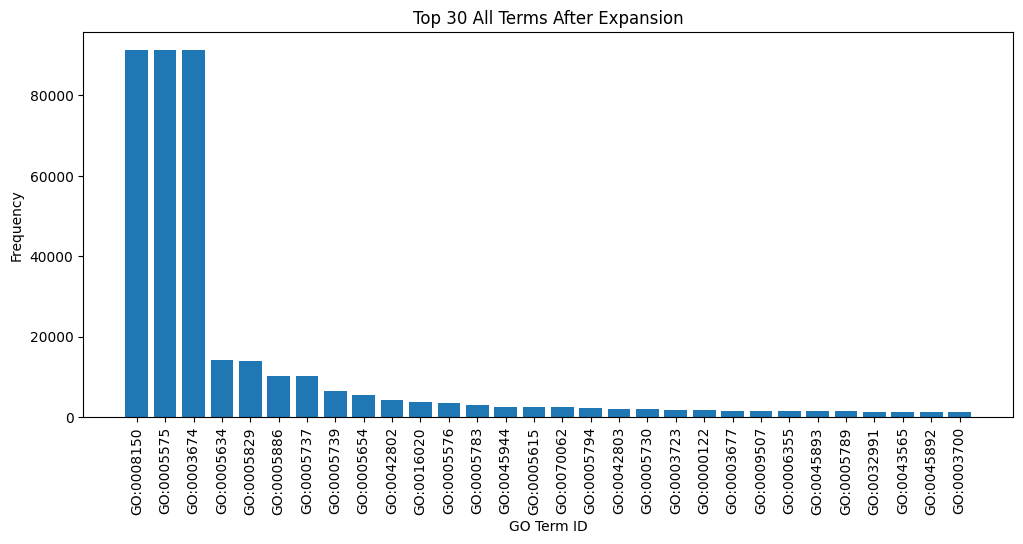

Total terms before/after: 555,298/828,019
Average terms before/after: 20.76/31.06
Invalid/deprecated terms: 97
Dataset saved to ./dataset/all-expanded.jsonl


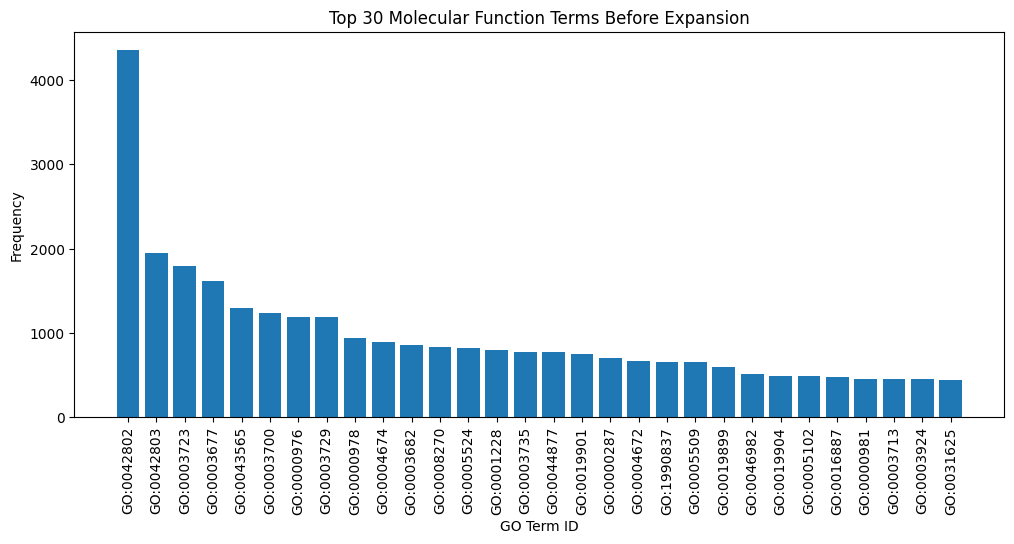

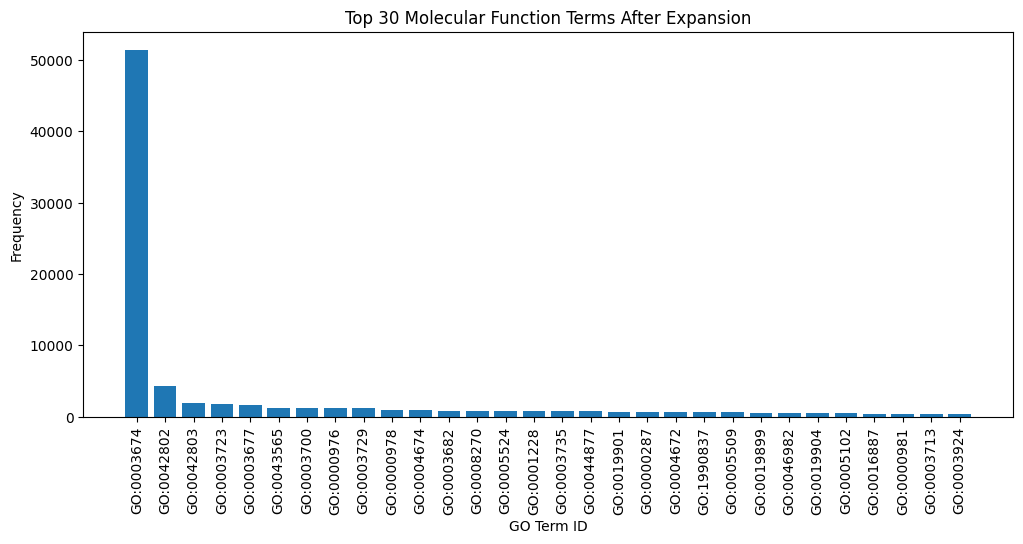

Total terms before/after: 105,306/156,568
Average terms before/after: 15.38/22.94
Invalid/deprecated terms: 21
Dataset saved to ./dataset/mf-expanded.jsonl


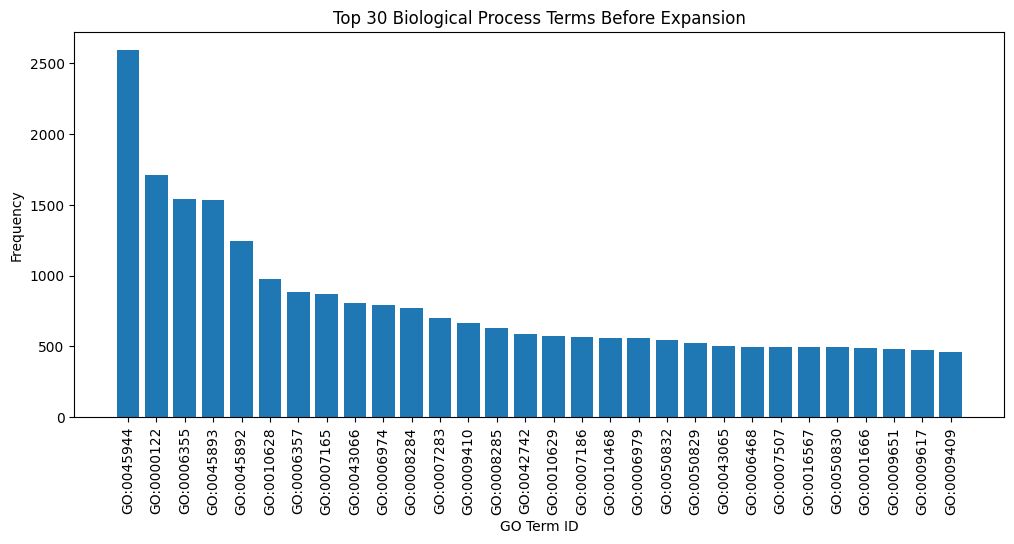

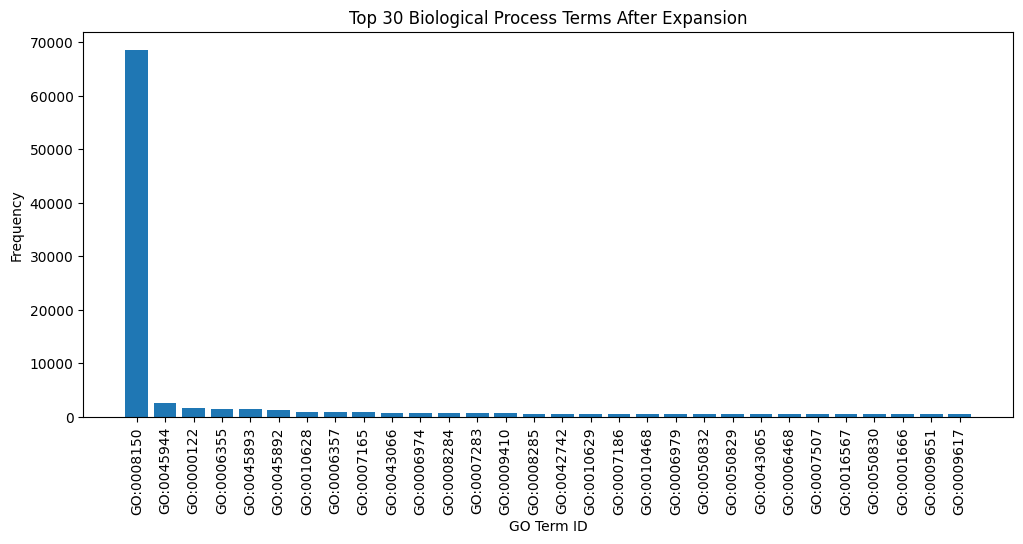

Total terms before/after: 278,160/345,966
Average terms before/after: 16.20/20.23
Invalid/deprecated terms: 71
Dataset saved to ./dataset/bp-expanded.jsonl


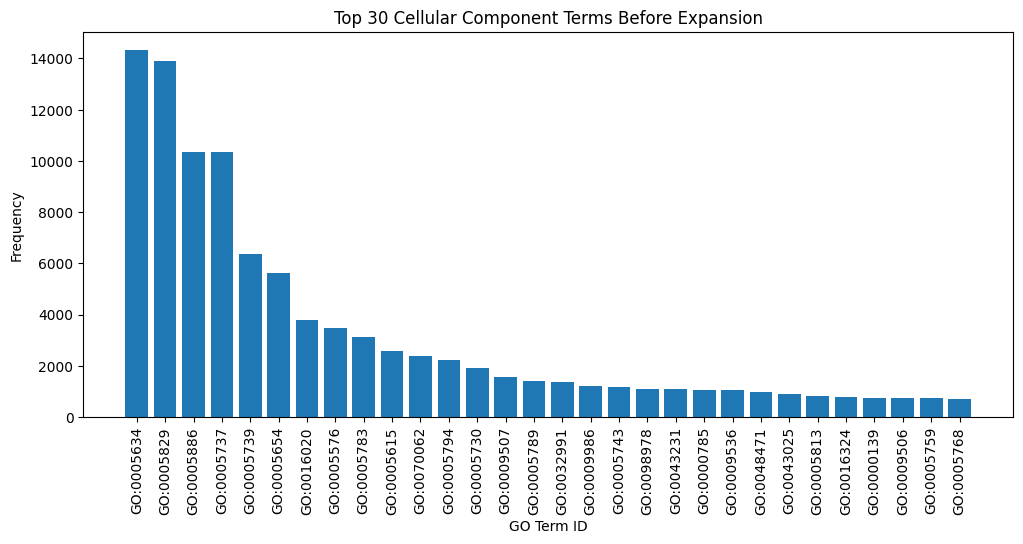

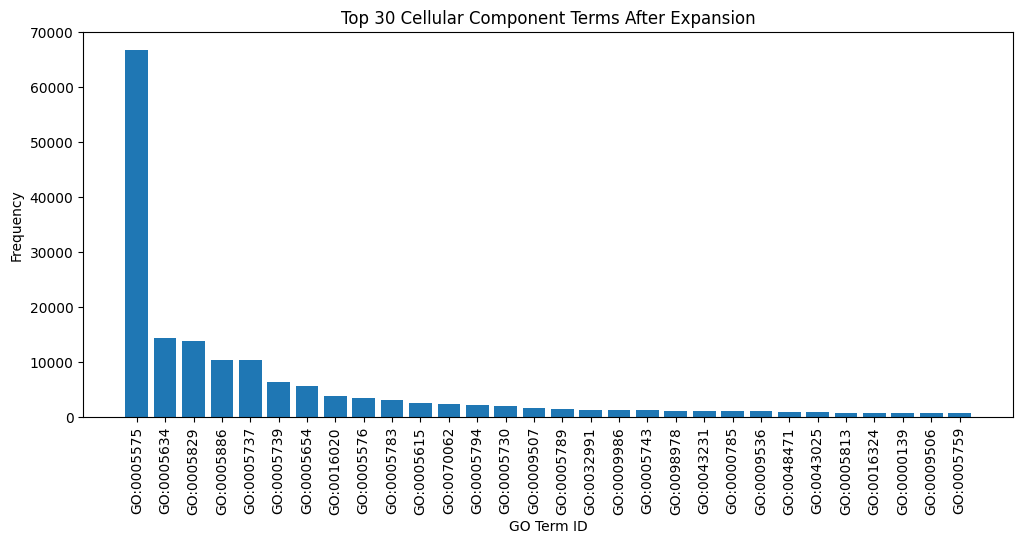

Total terms before/after: 171,832/238,468
Average terms before/after: 62.83/87.35
Invalid/deprecated terms: 5
Dataset saved to ./dataset/cc-expanded.jsonl


In [25]:
from datasets import load_dataset

import obonet

import networkx as nx

from collections import Counter

from itertools import islice

import matplotlib.pyplot as plt

import json

all_dataset_path = "./dataset/all-filtered.jsonl"
mf_dataset_path = "./dataset/mf-filtered.jsonl"
bp_dataset_path = "./dataset/bp-filtered.jsonl"
cc_dataset_path = "./dataset/cc-filtered.jsonl"

all_expanded_path = "./dataset/all-expanded.jsonl"
mf_expanded_path = "./dataset/mf-expanded.jsonl"
bp_expanded_path = "./dataset/bp-expanded.jsonl"
cc_expanded_path = "./dataset/cc-expanded.jsonl"

top_k = 30

go_obo_path = "./dataset/go-basic.obo"

graph = obonet.read_obo(go_obo_path)

MF_ROOT_NODE = "GO:0003674"
BP_ROOT_NODE = "GO:0008150"
CC_ROOT_NODE = "GO:0005575"

if not nx.is_directed_acyclic_graph(graph):
    raise ValueError("Invalid gene ontology graph, must not contain cycles.")

for name, dataset_path, expanded_path, root_nodes in [
    ("All", all_dataset_path, all_expanded_path, {MF_ROOT_NODE, BP_ROOT_NODE, CC_ROOT_NODE}),
    ("Molecular Function", mf_dataset_path, mf_expanded_path, {MF_ROOT_NODE,}),
    ("Biological Process", bp_dataset_path, bp_expanded_path, {BP_ROOT_NODE,}),
    ("Cellular Component", cc_dataset_path, cc_expanded_path, {CC_ROOT_NODE,}),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    before_counter = Counter()
    after_counter = Counter()

    with open(expanded_path, "w") as file:
        for record in dataset:
            original_terms = set(record["go_terms"])

            for term in original_terms:
                before_counter[term] += 1

            node_ids = root_nodes | original_terms

            subgraph = graph.subgraph(node_ids)

            if not nx.is_directed_acyclic_graph(subgraph):
                continue

            expanded_terms = set()

            for node in subgraph.nodes:
                expanded_terms.add(node)

                for descendant in nx.descendants(subgraph, node):
                    expanded_terms.add(descendant)

            if not expanded_terms.difference(root_nodes):
                continue

            for term in expanded_terms:
                after_counter[term] += 1
            
            record["go_terms"] = list(expanded_terms)

            file.write(json.dumps(record) + "\n")

    for when, counter, in (("Before", before_counter), ("After", after_counter)):
        counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

        first_k = dict(islice(counter.items(), top_k))

        plt.figure(figsize=(12, 5)) 

        plt.bar(first_k.keys(), first_k.values())

        plt.title(f"Top {top_k} {name} Terms {when} Expansion")
        plt.xticks(rotation=90)
        plt.xlabel("GO Term ID")
        plt.ylabel("Frequency")

        plt.show()

    total_before = before_counter.total()
    total_after = after_counter.total()

    unique_before = len(before_counter)
    unique_after = len(after_counter)

    average_before = total_before / unique_before
    average_after = total_after / unique_after

    orphaned_terms = unique_before - unique_after

    print(f"Total terms before/after: {total_before:,}/{total_after:,}")
    print(f"Average terms before/after: {average_before:.2f}/{average_after:.2f}")
    print(f"Invalid/deprecated terms: {orphaned_terms:,}")

    print(f"Dataset saved to {expanded_path}")
                